# TrAnET Pipeline

This notebook contains the steps to run the demo of the `TrAnET` system, in particular: 

1) Dataset cleaning and topic model computation 
2) Topics assignment
3) Topic diffusion analysis

### Precomputed model and assignments
A precomputed model, used during experiments, is available within the folder `demo_files`. Unzip the content of the archive and copy the files in the input/output folder specified within the `config.py` configuration file. 

The precomputed model refers to the following parameters: 

    training_starting_year      = 2000
    training_ending_year        = 2014
    number_of_topics_to_extract = 50
    training_venues             = sv.considered_venues
    
    use_lemmer                  = True
    min_doc_frequency           = 2
    max_doc_frequency           = 0.8

    analysis_starting_year      = 2000
    analysis_ending_year        = 2014
    analysis_venues             = sv.considered_venues
    
   

In [3]:
import sys
sys.path.append('..')

# print('Path configured.')

import config
import topic_modeling
from utilities import selected_venues as sv

print('Loaded configurations:\n')
template = '{0}: {1}'

print(template.format('Mongodb host', config.__host))
print(template.format('Mongodb port', config.__port))
print(template.format('Mongodb database name', config.__db_name))
print(template.format('Mongodb collection name', config.__collection_name))
print('')
print(template.format('Path of the input/output folder', config.__inputs_outputs_folder_path))
print(template.format('Absolute path of the resources folder', config.__resources_folder_path))

Loaded configurations:

Mongodb host: localhost
Mongodb port: 27014
Mongodb database name: scipub
Mongodb collection name: dblp_papers

Path of the input/output folder: /path/to/outputs/folder
Absolute path of the resources folder: path/to/utilities/and/resources


# Topic model training

Define the needed parameters and run the computation. The model will be stored in the input/output folder.

In [21]:
# the starting year to train the model 
training_starting_year      = 2000
# the ending year to train the model 
training_ending_year        = 2014
# the number of topics to search for 
number_of_topics_to_extract = 50
# venues to consider
training_venues             = sv.considered_venues

# Cleaning parameters 
# use the lemmer to standardize terms
use_lemmer                  = True
# terms that appears in less than min_doc_frequency documents are ignored
min_doc_frequency           = 2
# terms that appears in more than max_doc_frequency * n_documents documents are ignored
max_doc_frequency           = 0.8

In [ ]:
topic_modeling.compute_topic_model(training_starting_year, training_ending_year, training_venues, number_of_topics_to_extract, use_lemmer, min_doc_frequency, max_doc_frequency)

Model loaded.


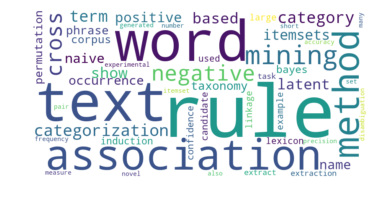

In [3]:
# Load the computed topic model and print a topic wordcloud
topic_model = topic_modeling.load_saved_model(training_starting_year, training_ending_year, training_venues, number_of_topics_to_extract, output_folder=config.__inputs_outputs_folder_path)

print('Model loaded.')

topic_id = number_of_topics_to_extract - 1
topic_description = topic_model.show_topic(topic_id, 50)
topic_modeling.generate_wordcloud(topic_description, use_mask='rect', store_to_file=False)

# Topics assignment

Define the needed parameters and run the computation. The topic assignments will be stored in a csv file in the input/output folder. 

In [2]:
# Parameters of the model to load 

# the starting year to train the model 
training_starting_year      = 2000
# the ending year to train the model 
training_ending_year        = 2014
# the number of topics to search for 
number_of_topics_to_extract = 50
# venues to consider
training_venues             = sv.considered_venues

# Parameters of the documents to assign 

# the starting year to train the model 
analysis_starting_year      = 2000
# the ending year to train the model 
analysis_ending_year        = 2014
# venues to consider
analysis_venues             = sv.considered_venues

In [ ]:
topic_modeling.assign_topics_and_save(training_starting_year, training_ending_year, number_of_topics_to_extract,
                               analysis_starting_year, analysis_ending_year, training_venues=training_venues,
                               analysis_venues=analysis_venues)

# Topics diffusion



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient(config.__host, config.__port)
#papers_collection = client.scipub.dblp_papers
papers_collection = client[config.__db_name][config.__collection_name]

In [5]:
# constants

# minimum value of weight parameter on topic for deciding that a paper concerns the topic
minimum_topic_weight = 0.2
# the starting year for studying the topic diffusion: it must be in the range (training_starting_year, training_ending_year)
diffusion_starting_year      = 2000
# the ending year for studying the topic diffusion: it must be in the range [diffusion_starting_year, training_ending_year)
diffusion_ending_year        = 2014


#### Statistics on papers

In [6]:
#get dataframe of items <paper_id, year, topic_id, topic_weight>
def get_papers():
    # get topics for each paper
    paper_topics = pd.read_csv("../demo_files/2000-2014-50-2000-2014-paper-topicid.csv", sep=';')
    # get year of each paper
    pipeline = [
                {'$match': {'year': {'$gte': diffusion_starting_year, '$lte': diffusion_ending_year}}}, # filter years
                {"$project": {'acm_id': '$acm_id', 'year':'$year'}}
    ]

    result = papers_collection.aggregate(pipeline)
    paper_year =  pd.DataFrame(list(result))
    del paper_year['_id']
    # merge for assigning topic and year to each paper
    res = paper_topics.merge(paper_year, how = "left", left_on = "acm_id", right_on = "acm_id")
    res.dropna(inplace=True)  # delete unfound years, if any
    return res

#plot dataframe of items <paper_id, year, topic_id>
def plot_papers_overview(csv, index, columns, cmap=plt.cm.Vega20):
    t = csv[csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=columns, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("papers")
    plt.show()
    plt.gcf().clear()
    return

In [7]:
#get dataframe of items <paper_id, year, topic_id, topic_weight>
papers_csv = get_papers()

Number of papers concerning a topic by year


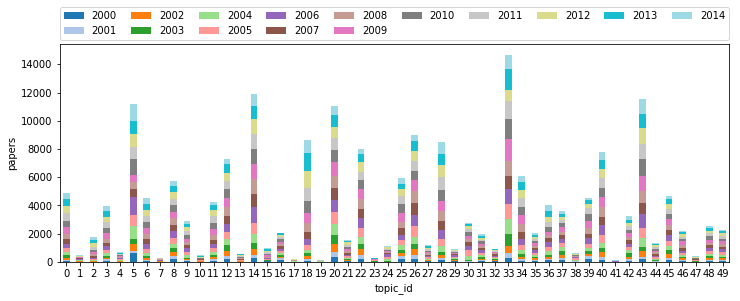

Number of papers published in each year by topic


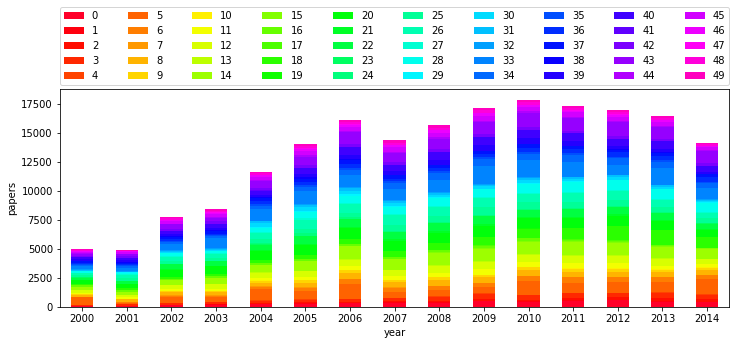

In [8]:
print("Number of papers concerning a topic by year")
plot_papers_overview(papers_csv, 'topic_id', 'year')

print("Number of papers published in each year by topic")
plot_papers_overview(papers_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow)


#### Statistics on authors

In [9]:
#get dataframe of items <paper_id, author_name, year, topic_id, topic_weight>
def get_authors():
    # get topics for each paper
    paper_topics = pd.read_csv("../demo_files/2000-2014-50-2000-2014-paper-topicid.csv", sep=';')
    # get years and authors of each paper
    pipeline = [
                {'$match': {'year': {'$gte': diffusion_starting_year, '$lte': diffusion_ending_year}}}, # filter years
                {'$unwind': '$authors'}, 
                {"$project": {'acm_id': '$acm_id', 'year':'$year', 'author': '$authors'}}
    ]

    result = papers_collection.aggregate(pipeline)
    paper_year_authors =  pd.DataFrame(list(result))
    del paper_year_authors['_id']
    # merge for assigning topic and year to each author
    res = paper_topics.merge(paper_year_authors, how = "left", left_on = "acm_id", right_on = "acm_id")
    res.dropna(inplace=True)  # delete unfound years, if any
    res[['year']] = res[['year']].astype(int)
    return res

#plot dataframe of items <paper_id, author_name, year, topic_id> letting the authors to repeat in the count
def plot_authors_overview(index, column, cmap=plt.cm.Vega20):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=column, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    plt.show()
    plt.gcf().clear()
    return

#plot dataframe of items <paper_id, author_name, year, topic_id> where the authors are not repeated in the count
def plot_authors_norep_overview(index, column, cmap=plt.cm.Vega20):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].groupby(["topic_id","year","author"]).count().reset_index().groupby(["topic_id","year"]).count().reset_index().pivot_table(index=index, columns=column, values='acm_id', aggfunc='sum')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    plt.show()
    plt.gcf().clear()
    return

#plot number of topics concerned by an author
def plot_author_overview(author, index, column, cmap=plt.cm.Vega20, weight=minimum_topic_weight):
    t = authors_csv[(authors_csv["author"] == author) & (authors_csv["topic_weight"] >= weight)].pivot_table(index=index, columns=column, values='topic_weight', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(ncol=2)
    plt.ylabel("papers")
    plt.show()
    plt.gcf().clear()
    return

In [10]:
#get dataframe of items <paper_id, author_name, year, topic_id, topic_weight>
authors_csv = get_authors()

Number of authors (with repetitions) concerning a topic by year


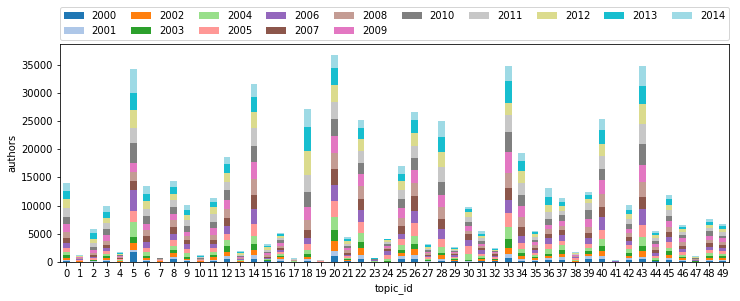

Number of authors (with repetitions) publishing a paper in each year by topic


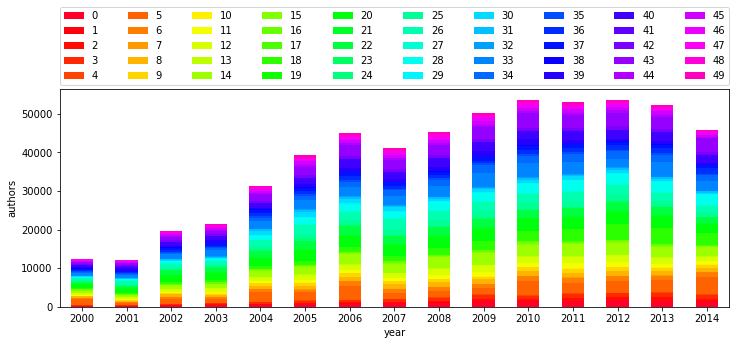

In [11]:
print("Number of authors (with repetitions) concerning a topic by year")
plot_authors_overview('topic_id', 'year')

print("Number of authors (with repetitions) publishing a paper in each year by topic")
plot_authors_overview('year', 'topic_id', cmap=plt.cm.gist_rainbow)

Number of authors (without repetitions) concerning a topic by year


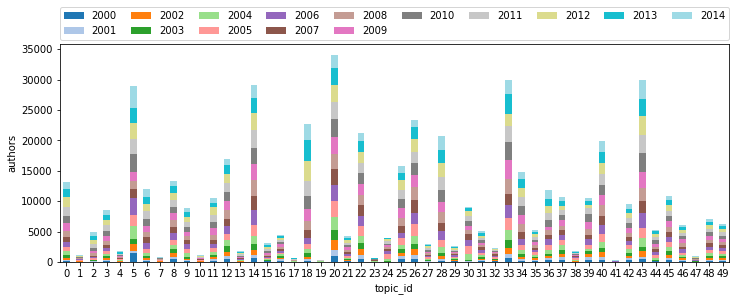

Number of authors (without repetitions) publishing a paper in each year by topic


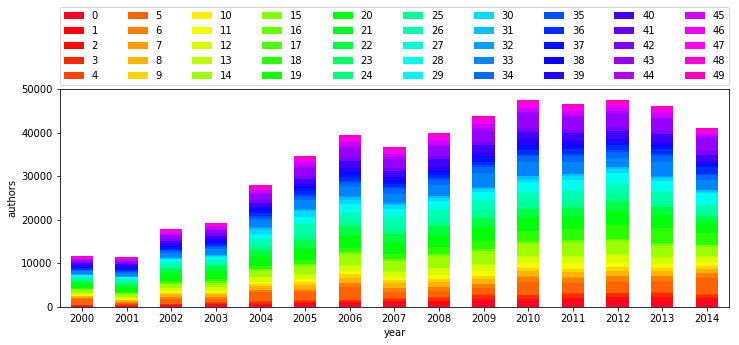

In [12]:
print("Number of authors (without repetitions) concerning a topic by year")
plot_authors_norep_overview('topic_id', 'year')

print("Number of authors (without repetitions) publishing a paper in each year by topic")
plot_authors_norep_overview('year', 'topic_id', cmap=plt.cm.gist_rainbow)

number of topics concerned by Jeffrey Xu Yu by year


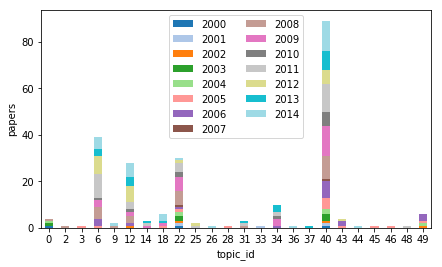

number of topics concerned by Jeffrey Xu Yu in each year by topic


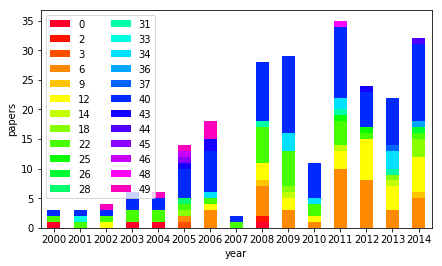

In [13]:
print("number of topics concerned by Jeffrey Xu Yu by year")
plot_author_overview("Jeffrey Xu Yu", 'topic_id', 'year')

print("number of topics concerned by Jeffrey Xu Yu in each year by topic")
plot_author_overview("Jeffrey Xu Yu", 'year', 'topic_id', cmap=plt.cm.gist_rainbow)

#### Topic diffusion

In [14]:
#get dataframe that count the number of authors by year and topic_id
#   all_authors: all the authors publishing a paper on the topic in the year
#   new_authors: the same of all_authors, but the authors already found in previous years are not counted
#   *_cumulative: cumulative of *
def count_authors_by_topic(topic_id_list):
    result = {"topic_id": [], "year": [], "all_authors": [], "new_authors": [], "all_authors_cumulative": [], "new_authors_cumulative": []}
    for topic_id in topic_id_list:
        total_authors_sum = 0
        new_authors_sum = 0
        all_authors = []
        year_from = authors_csv["year"].min(); year_to = authors_csv["year"].max() + 1
        for year in range(year_from, year_to):
            result["topic_id"] += [topic_id]
            result["year"] += [year]
            authors_of_year = set(authors_csv[(authors_csv["topic_weight"] >= minimum_topic_weight) & (authors_csv["year"] == year) & (authors_csv["topic_id"] == topic_id)]["author"])
            total_authors_sum += len(authors_of_year)
            result["all_authors"] += [len(authors_of_year)]
            result["all_authors_cumulative"] += [total_authors_sum]
            # count new authors
            new_authors = list(authors_of_year - set(all_authors))
            new_authors_sum += len(new_authors)
            #new_authors_count += [new_authors_sum]
            result["new_authors"] += [len(new_authors)]
            result["new_authors_cumulative"] += [new_authors_sum]
            all_authors += new_authors   
    return pd.DataFrame(result)

#calculate time windows
def get_time_windows(year_from, year_to, time_window, overlap):
    time_window-=1; overlap -= 1; year_to+= 1
    res = []
    i = 0
    while (year_from + i*(time_window-overlap) + time_window) < year_to:
        res += [[year_from + i*(time_window-overlap), year_from + i*(time_window-overlap) + time_window]]
        i += 1
    return res

#get the citations tree of a list of papers in a range of years
def get_paper_citations_tree(target_list, year_from, year_to):
    new_target_list = set(target_list)
    result_list = []
    mongo_input_limit = 400000 # limits of results Mongo can get

    while bool(new_target_list):
        temp_result_list = []
        for i in range(int(len(new_target_list)/mongo_input_limit)+1):
            pipeline = [
                {'$match': {'year': {'$gte': year_from, '$lte': year_to}}}, # filter years
                {'$match': {'cleaned_venue': {'$in': sv.considered_venues}}}, # filter venues
                {'$match': {'acm_citations': {'$in': list(new_target_list)[i*mongo_input_limit:(i+1)*mongo_input_limit] }}},
                {"$project": {'acm_id': '$acm_id'}},
            ]

            result = papers_collection.aggregate(pipeline)
            temp_result_list += list(result)
        new_target_list = set([x['acm_id'] for x in list(temp_result_list)])-set(result_list)
        result_list += list(new_target_list)
    return result_list

#get dataframe that count the number of authors that have cited a paper published on topic in the previous time window
#the first time window is the year time_windows[0][0]
#   all_authors: all the authors citing a paper in the previous time window
#   new_authors: the same of all_authors, but the authors already found in previous time windows are not counted
#   all_authors_intopic: all the authors citing with a paper on topic a paper in the previous time window
#   new_authors_intopic: the same of all_authors_intopic, but the authors already found in previous time windows are not counted
#   *_cumulative: cumulative of *
def count_authors_by_topic_time_windows(topic_id_list, time_windows):
    year_from = time_windows[0][0]-1
    result = {"topic_id": [], "time_window_from": [], "time_window_to": [], "all_authors": [], "new_authors": [], "all_authors_cumulative": [], "new_authors_cumulative": [], "all_authors_intopic": [], "new_authors_intopic": [], "all_authors_intopic_cumulative": [], "new_authors_intopic_cumulative": []}
    for topic_id in topic_id_list:
        source_papers = list(papers_csv[(papers_csv["year"] == year_from) & (papers_csv["topic_id"] == topic_id) & (papers_csv["topic_weight"] >= minimum_topic_weight)]["acm_id"])
        sum_authors = 0; sum_new_authors = 0; sum_authors_in_topic = 0; sum_new_authors_in_topic = 0
        all_authors = list(authors_csv[authors_csv["acm_id"].isin(source_papers)]["author"])#[]
        all_authors_in_topic = list(authors_csv[authors_csv["acm_id"].isin(source_papers)]["author"])#[]
        for time_window in time_windows:
            result["topic_id"] += [topic_id]
            result["time_window_from"] += [time_window[0]]
            result["time_window_to"] += [time_window[1]]
            paper_citations_tree = pd.DataFrame(get_paper_citations_tree(source_papers, time_window[0], time_window[1]), columns=["acm_id"]).merge(authors_csv, how = "left", left_on = "acm_id", right_on = "acm_id")
            authors_of_time_window = set(paper_citations_tree["author"])
            sum_authors += len(authors_of_time_window)
            result["all_authors"] += [len(authors_of_time_window)]
            result["all_authors_cumulative"] += [sum_authors]
            new_authors = list(authors_of_time_window - set(all_authors))
            sum_new_authors += len(new_authors)
            result["new_authors"] += [len(new_authors)]
            result["new_authors_cumulative"] += [sum_new_authors]
            all_authors += new_authors  
            # autohrs in topic
            authors_of_time_window_in_topic = set(paper_citations_tree[(paper_citations_tree["topic_id"] == topic_id) & (paper_citations_tree["topic_weight"] >= minimum_topic_weight)]["author"])
            sum_authors_in_topic += len(authors_of_time_window_in_topic)
            result["all_authors_intopic"] += [len(authors_of_time_window_in_topic)]
            result["all_authors_intopic_cumulative"] += [sum_authors_in_topic]
            new_authors_in_topic = list(authors_of_time_window_in_topic - set(all_authors_in_topic))
            sum_new_authors_in_topic += len(new_authors_in_topic)
            result["new_authors_intopic"] += [len(new_authors_in_topic)]
            result["new_authors_intopic_cumulative"] += [sum_new_authors_in_topic]
            all_authors_in_topic += new_authors_in_topic
            # update
            source_papers = paper_citations_tree[(paper_citations_tree["topic_id"] == topic_id) & (paper_citations_tree["topic_weight"] >= minimum_topic_weight)].groupby("acm_id").first().reset_index()["acm_id"]
    return pd.DataFrame(result)


In [15]:
#parameters
#list of topic ids under consideration. Each item must be in the range [0, number_of_topics_to_extract)
topic_ids = [6,34]
#length, in years, of time window
time_window = 4
#overlap, in years, of time window
overlap = 3

In [16]:
#get dataframe that count the number of authors by year and topic_id
authors_by_topic = count_authors_by_topic(topic_ids)


In [17]:
#get dataframe that count the number of authors that have cited a paper published on topic in the previous time window
authors_by_topic_time_windows = count_authors_by_topic_time_windows(topic_ids, get_time_windows(diffusion_starting_year+1, diffusion_ending_year, time_window, overlap))


In [18]:
# plot a column of the dataframe that count the number of authors by year and topic_id 
def plot_authors_topic_single(csv, column):
    topic_id_list = csv["topic_id"].unique()
    colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        plt.plot(csv[csv["topic_id"] == topic_id]["year"], csv[csv["topic_id"] == topic_id][column], linestyle, color=color, label="topic "+str(topic_id))
    plt.legend()
    plt.show()
    plt.close()
    return

# plot a list of columns of the dataframe that count the number of authors by year and topic_id 
def plot_authors_topic_multi(csv, columns, labels):
    topic_id_list = csv["topic_id"].unique()
    colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for index, (column, linestyle, label) in enumerate(zip(columns, linestyles, labels)):
        for topic_id, color in zip(topic_id_list, colors):
            plt.plot(csv[csv["topic_id"] == topic_id]["year"], csv[csv["topic_id"] == topic_id][column], linestyle, color=color, label="_none")
            if index == 0:
                plt.bar(csv[csv["topic_id"] == topic_id]["year"].values[0], [0], color=color, label="topic "+str(topic_id))
        plt.plot([], [], linestyle, color="grey", label=label)
    plt.legend()
    plt.show()
    plt.close()
    return

# plot a column of the dataframe that count the number of authors that have cited a paper published on topic in the previous time window.
def plot_authors_topic_time_windows_single(csv, column):
    topic_id_list = csv["topic_id"].unique()
    colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        plt.plot(csv[csv["topic_id"] == topic_id]["time_window_to"], csv[csv["topic_id"] == topic_id][column], linestyle, color=color, label="topic "+str(topic_id))
    plt.xticks(csv[csv["topic_id"] == topic_id]["time_window_to"][::2], [str(x)[-2:]+"-"+str(y)[-2:] for x, y in zip(csv[csv["topic_id"] == topic_id]["time_window_from"][::2], csv[csv["topic_id"] == topic_id]["time_window_to"][::2])])#, rotation=45, horizontalalignment='right')
    plt.legend()
    plt.show()
    plt.close()
    return

# plot a list of columns of the dataframe that count the number of authors that have cited a paper published on topic in the previous time window.
def plot_authors_topic_time_windows_multi(csv, columns, labels):
    topic_id_list = csv["topic_id"].unique()
    colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for index, (column, linestyle, label) in enumerate(zip(columns, linestyles, labels)):
        for topic_id, color in zip(topic_id_list, colors):
            plt.plot(csv[csv["topic_id"] == topic_id]["time_window_to"], csv[csv["topic_id"] == topic_id][column], linestyle, color=color, label="_none")
            if index == 0:
                plt.bar(csv[csv["topic_id"] == topic_id]["time_window_to"].values[0], [0], color=color, label="topic "+str(topic_id))
        plt.plot([], [], linestyle, color="grey", label=label)
    plt.xticks(csv[csv["topic_id"] == topic_id]["time_window_to"][::2], [str(x)[-2:]+"-"+str(y)[-2:] for x, y in zip(csv[csv["topic_id"] == topic_id]["time_window_from"][::2], csv[csv["topic_id"] == topic_id]["time_window_to"][::2])])#, rotation=45, horizontalalignment='right')
    plt.legend()
    plt.show()
    plt.close()
    return

# mix plot_authors_topic_single and plot_authors_topic_time_windows_single
def plot_authors_topic_mixed(csv_authors_topic, csv_authors_topic_time_windows, column_authors_topic, column_authors_topic_time_windows, label_authors_topic, label_authors_topic_time_windows):
    topic_id_list = csv_authors_topic["topic_id"].unique()
    colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    for topic_id, color in zip(topic_id_list, colors):
        plt.plot(csv_authors_topic[csv_authors_topic["topic_id"] == topic_id]["year"], csv_authors_topic[csv_authors_topic["topic_id"] == topic_id][column_authors_topic], "--", color=color, label="_none")
        plt.plot(csv_authors_topic_time_windows[csv_authors_topic_time_windows["topic_id"] == topic_id]["time_window_to"], csv_authors_topic_time_windows[csv_authors_topic_time_windows["topic_id"] == topic_id][column_authors_topic_time_windows], "-", color=color, label="_none")#, label="topic "+str(topic_id))
        plt.bar(csv_authors_topic_time_windows[csv_authors_topic_time_windows["topic_id"] == topic_id]["time_window_to"].values[0], [0], color=color, label="topic "+str(topic_id))
    plt.plot([], [], '--', color="grey", label=label_authors_topic)
    plt.plot([], [], '-', color="grey", label=label_authors_topic_time_windows)
    plt.xticks(csv_authors_topic[csv_authors_topic["topic_id"] == topic_id]["year"], [str(x) for x in range(csv_authors_topic[csv_authors_topic["topic_id"] == topic_id]["year"].min(), csv_authors_topic_time_windows[csv_authors_topic_time_windows["topic_id"] == topic_id]["time_window_to"].min())]+[str(x[0])[-2:]+"-"+str(x[1])[-2:] for x in csv_authors_topic_time_windows[csv_authors_topic_time_windows["topic_id"] == topic_id][["time_window_from","time_window_to"]].values], rotation='vertical')
    plt.legend()
    plt.show()
    plt.close()
    return

Figure 2.a of paper: Diffusion on network


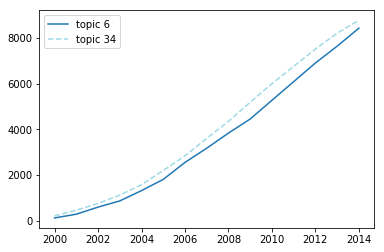

Figure 2.b of paper: Speed of evolution


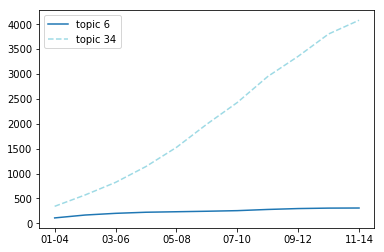

In [19]:
print("Figure 2.a of paper: Diffusion on network")
plot_authors_topic_single(authors_by_topic, "new_authors_cumulative")

print("Figure 2.b of paper: Speed of evolution")
plot_authors_topic_time_windows_single(authors_by_topic_time_windows, "new_authors_intopic_cumulative")


Number of authors publishing a paper on topic


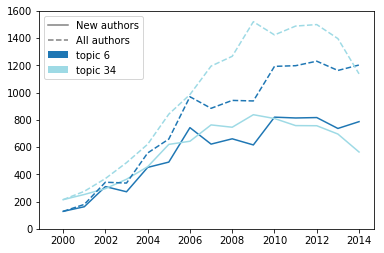

Number of authors publishing a paper on topic (cumulative)


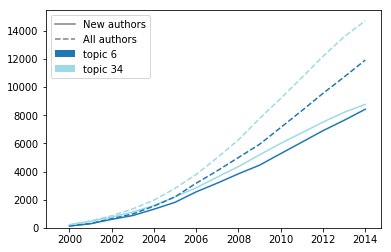

In [20]:
print("Number of authors publishing a paper on topic")
plot_authors_topic_multi(authors_by_topic, ["new_authors","all_authors"], ["New authors","All authors"])
print("Number of authors publishing a paper on topic (cumulative)")
plot_authors_topic_multi(authors_by_topic, ["new_authors_cumulative","all_authors_cumulative"], ["New authors","All authors"])

Number of authors citing a paper in the previous time window


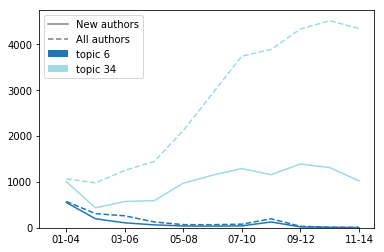

Number of authors citing a paper in the previous time window (cumulative)


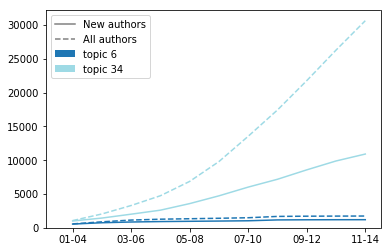

Number of authors publishing a paper on topic that cites a paper in the previous time window


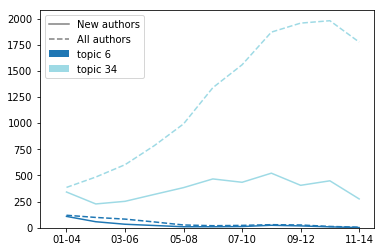

Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)


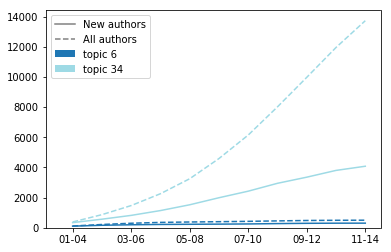

Number of authors citing a paper in the previous time window


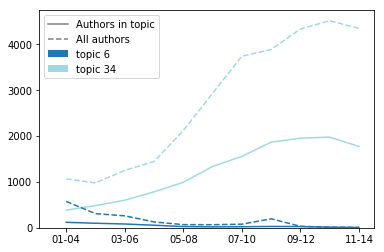

Number of authors citing a paper in the previous time window (cumulative)


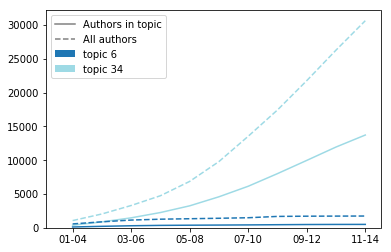

Number of authors publishing a paper on topic that cites a paper in the previous time window


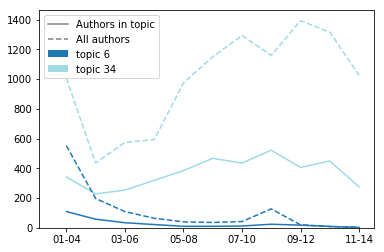

Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)


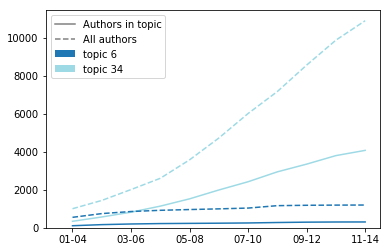

In [21]:
print("Number of authors citing a paper in the previous time window")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors","all_authors"], ["New authors","All authors"])
print("Number of authors citing a paper in the previous time window (cumulative)")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors_cumulative","all_authors_cumulative"], ["New authors","All authors"])
print("Number of authors publishing a paper on topic that cites a paper in the previous time window")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors_intopic","all_authors_intopic"], ["New authors","All authors"])
print("Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors_intopic_cumulative","all_authors_intopic_cumulative"], ["New authors","All authors"])

print("Number of authors citing a paper in the previous time window")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["all_authors_intopic","all_authors"], ["Authors in topic","All authors"])
print("Number of authors citing a paper in the previous time window (cumulative)")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["all_authors_intopic_cumulative","all_authors_cumulative"], ["Authors in topic","All authors"])
print("Number of authors publishing a paper on topic that cites a paper in the previous time window")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors_intopic","new_authors"], ["Authors in topic","All authors"])
print("Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)")
plot_authors_topic_time_windows_multi(authors_by_topic_time_windows, ["new_authors_intopic_cumulative","new_authors_cumulative"], ["Authors in topic","All authors"])


Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)


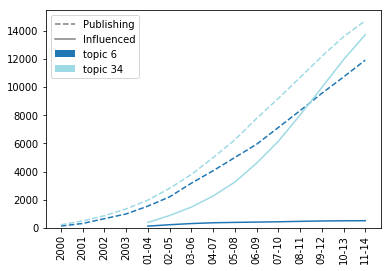

Number of new authors publishing a paper on topic that cites a paper in the previous time window (cumulative)


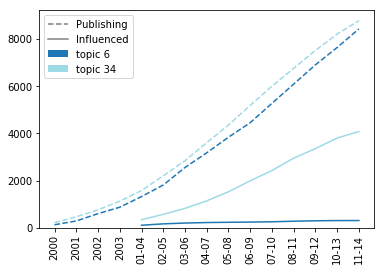

In [22]:
print("Number of authors publishing a paper on topic that cites a paper in the previous time window (cumulative)")
plot_authors_topic_mixed(authors_by_topic, authors_by_topic_time_windows, "all_authors_cumulative", "all_authors_intopic_cumulative", "Publishing", "Influenced")

print("Number of new authors publishing a paper on topic that cites a paper in the previous time window (cumulative)")
plot_authors_topic_mixed(authors_by_topic, authors_by_topic_time_windows, "new_authors_cumulative", "new_authors_intopic_cumulative", "Publishing", "Influenced")
